I start by loading some packages and imports the data into a dataframe

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time

# Load the dataset

DATA_URL = r"steel+plates+faults\Faults.NNA"
dataset = pd.read_csv(DATA_URL, sep=r'\s+', header=None)

# assign column names
column_names = np.loadtxt(r"steel+plates+faults\Faults27x7_var", dtype=str)
dataset.columns = column_names




Here the first few rows gets displayed and the header of the dataset, which can be used get a idea of how the data is.

In [51]:
# Display the first few rows and basic information about the dataset
print("First few rows of the dataset:")

print(dataset.head())


First few rows of the dataset:
   X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0         42         50     270900     270944           267           17   
1        645        651    2538079    2538108           108           10   
2        829        835    1553913    1553931            71            8   
3        853        860     369370     369415           176           13   
4       1289       1306     498078     498335          2409           60   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           44              24220                     76   
1           30              11397                     84   
2           19               7972                     99   
3           45              18996                     99   
4          260             246930                     37   

   Maximum_of_Luminosity  ...  Orientation_Index  Luminosity_Index  \
0                    108  ...             0.8182           -0.2913   
1          

Now the information regarding type and the amount of data points for each featue is check, and the datasets is check for any null values.

In [52]:
print(" Dataset information:")
print(dataset.info())
# Check for missing values
print(dataset.isnull().sum())

 Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-nu

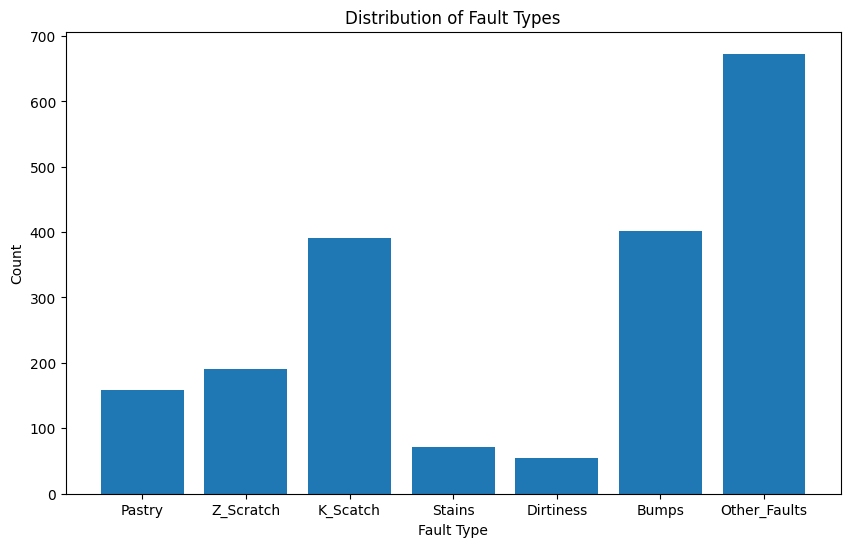

In [53]:
fault_type=["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

plt.figure(figsize=(10,6))
plt.bar(fault_type, dataset[fault_type].sum())
plt.title('Distribution of Fault Types')
plt.xlabel('Fault Type')
plt.ylabel('Count')
plt.savefig(r'images/fault_type_distribution.png', dpi=400)

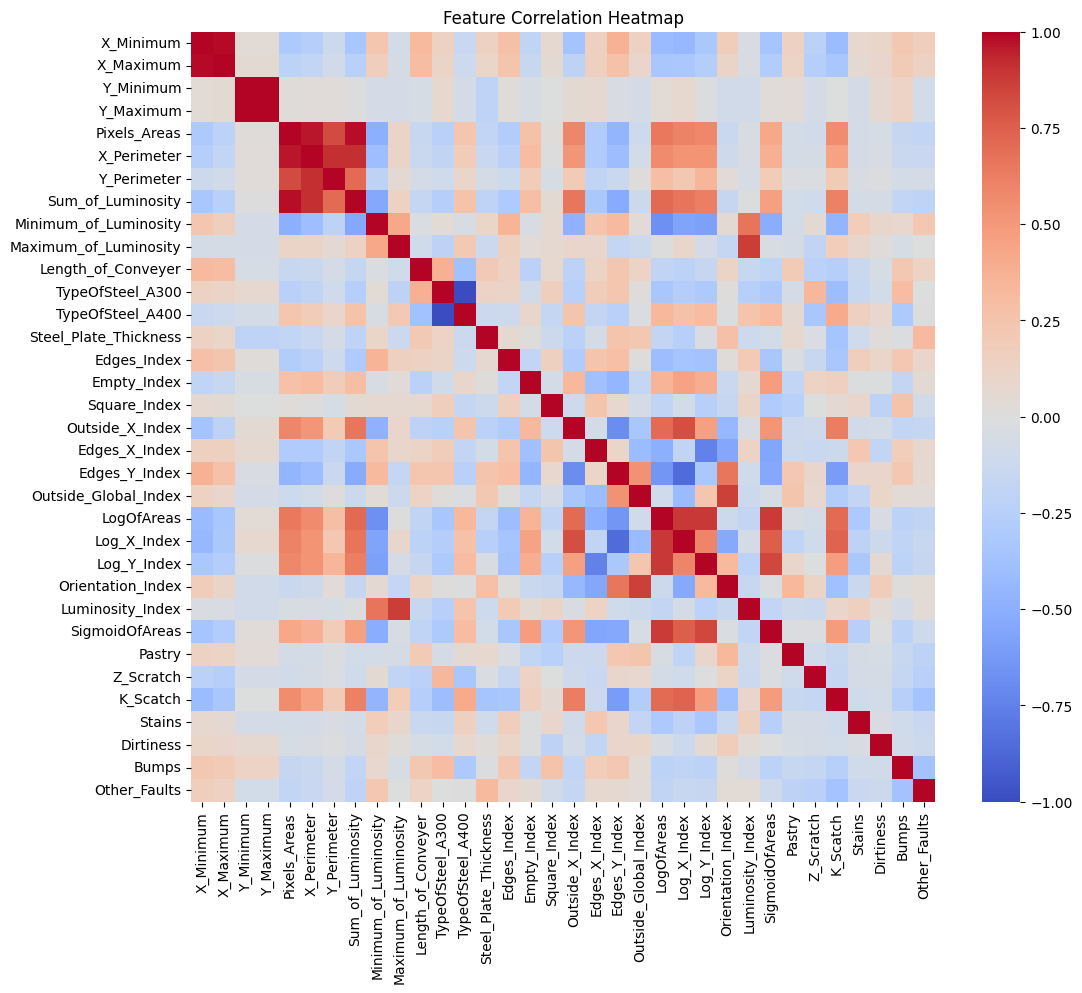

In [54]:
#display feature correlation heatmap to see the feature correlation
dataset.corr()
plt.figure(figsize=(12,10))
sns.heatmap(dataset.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.savefig(r'images/feature_correlation_heatmap.png', dpi=400)


binary_fault
1    1268
0     673
Name: count, dtype: int64


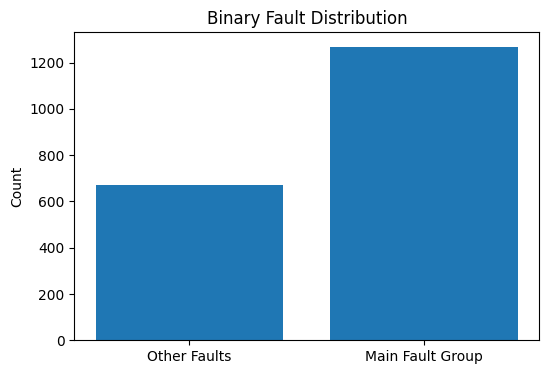

In [55]:
fault_cols = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps"]

# Creates a binary label: 1 = one of the above faults, 0 = Other_Faults
# which is done by checking if any of the fault columns have a value of 1
dataset["binary_fault"] = (dataset[fault_cols].sum(axis=1) > 0).astype(int)
print(dataset["binary_fault"].value_counts())

plt.figure(figsize=(6,4))
plt.bar(["1","2"],[len(dataset[dataset["binary_fault"] == 0]), len(dataset[dataset["binary_fault"] == 1])])
plt.xticks([0,1], ["Other Faults", "Main Fault Group"])
plt.ylabel("Count")
plt.title("Binary Fault Distribution")
plt.savefig(r'images/binary_fault_distribution.png', dpi=400)


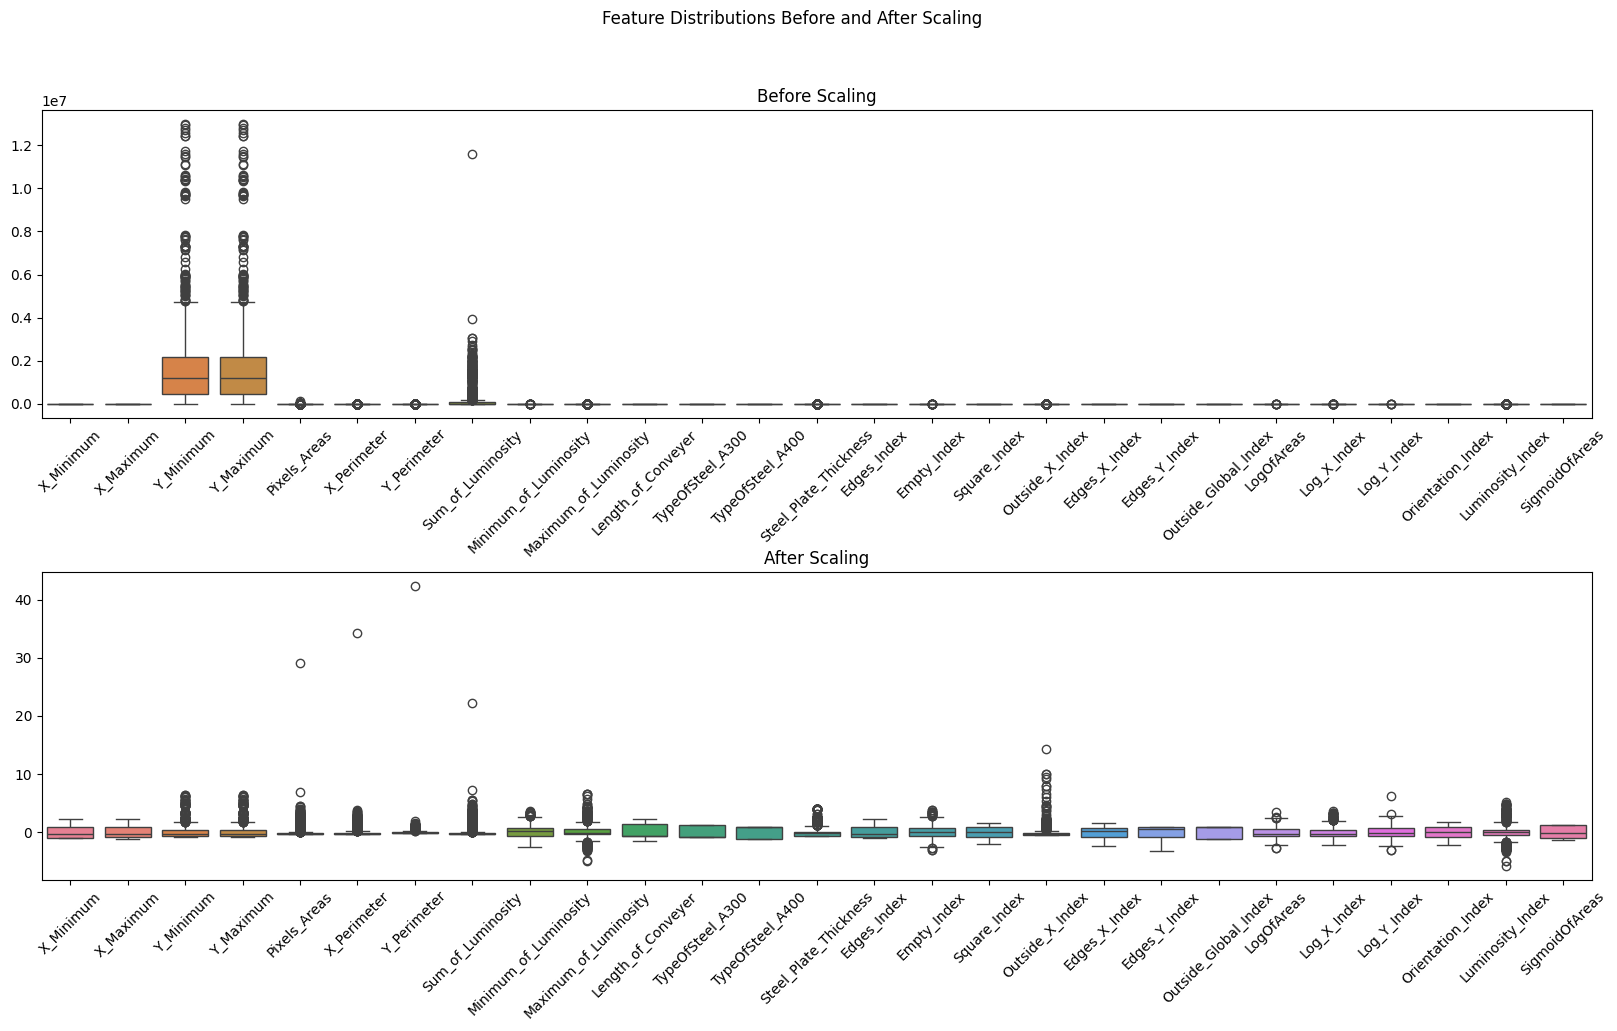

In [56]:
#first the orignal fauls columns are removed
#now the features and labels are extracted from the dataset
drop_columns = fault_type + ["binary_fault"]
x_df = dataset.drop(columns=drop_columns, axis=1)
y_df = dataset["binary_fault"]


# Standardize the features to have mean 0 and variance 1
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_df)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle('Feature Distributions Before and After Scaling')
sns.boxplot(data=pd.DataFrame(x_df, columns=x_df.columns), ax=ax1)
ax1.set_title('Before Scaling')
ax1.tick_params(axis='x', rotation=45)
plt.subplots_adjust(hspace=0.5)
sns.boxplot(data=pd.DataFrame(x_scaled, columns=x_df.columns), ax=ax2)
ax2.set_title('After Scaling')
ax2.tick_params(axis='x', rotation=45)

plt.savefig(r'images/feature_distributions_scaled_and_unscaled.png', dpi=400)




In [57]:
#grid search is used as an exhaustive search method to find the best hyperparameters for the logistic regression model
def grid_search_cv(x,y):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        "solver": ['liblinear', 'saga'],
        "penalty": ['l1', 'l2'],
        "max_iter": [100, 500, 1000]
    }
    
    grid_search = GridSearchCV(
        LogisticRegression(),
        param_grid,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    start_time = time.time()
    grid_search.fit(x, y)
    duration = time.time() - start_time
    
    return grid_search.best_params_, grid_search.best_score_, duration

best_params, best_score, duration = grid_search_cv(x_scaled, y_df)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Grid Search Duration (seconds):", duration)


Best Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Score: 0.6151776959160417
Grid Search Duration (seconds): 7.498100996017456


C:\Users\mikke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C:\Users\mikke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.7352185089974294

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.38      0.52       143
           1       0.72      0.94      0.82       246

    accuracy                           0.74       389
   macro avg       0.75      0.66      0.67       389
weighted avg       0.75      0.74      0.71       389



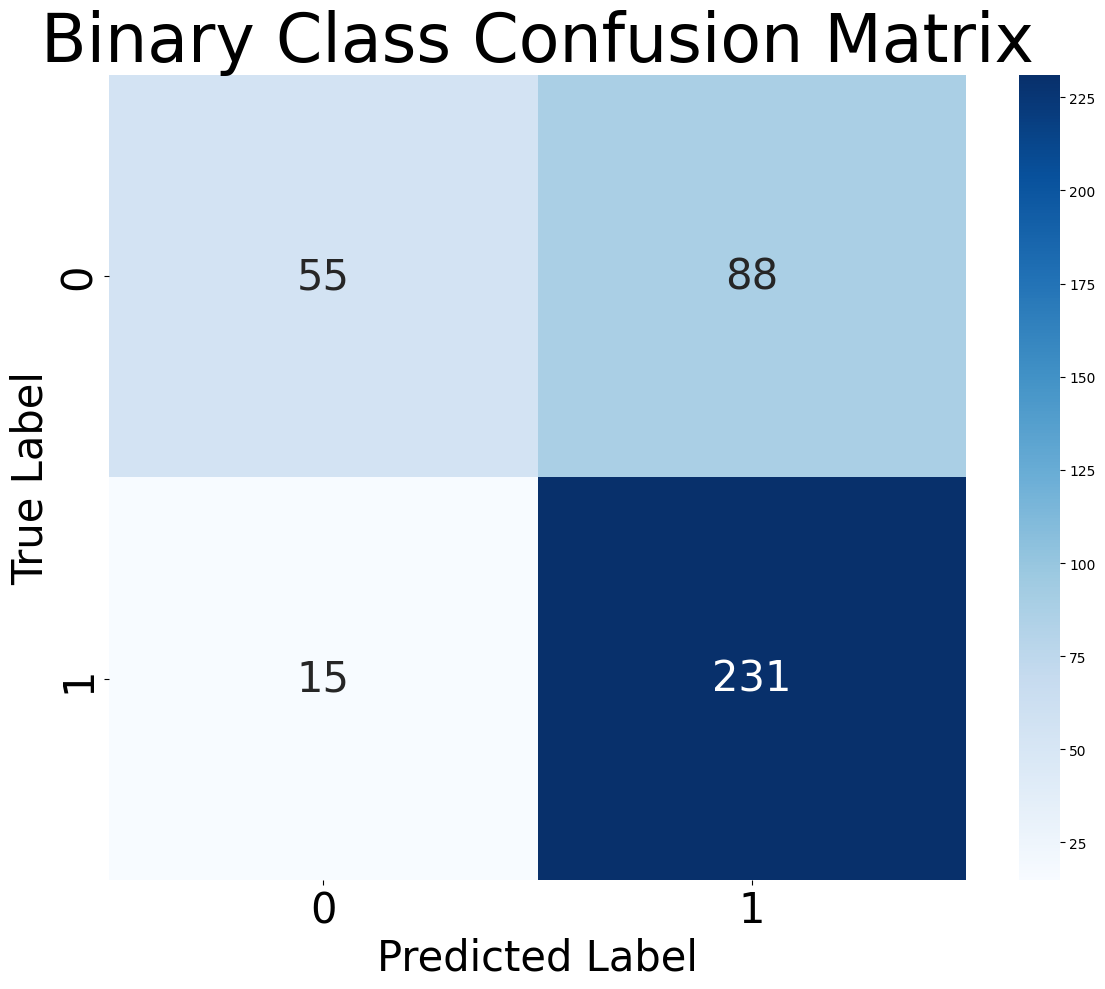

In [58]:

# Split the dataset into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_df, test_size=0.2, random_state=42)


# model using logistic regression with best params from grid search ** used to unpack the string
dt_classifier = LogisticRegression(**best_params)
dt_classifier.fit(x_train, y_train)

# Model Evaluation
y_pred = dt_classifier.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 30})
plt.title('Binary Class Confusion Matrix', fontsize= 48)
plt.ylabel('True Label',  fontsize= 30)
plt.xlabel('Predicted Label',  fontsize= 30)
plt.xticks(ticks=np.arange(len(dt_classifier.classes_))+0.5, labels=dt_classifier.classes_, fontsize=30)
plt.yticks(ticks=np.arange(len(dt_classifier.classes_))+0.5, labels=dt_classifier.classes_, fontsize=30)
plt.tight_layout()
plt.savefig(r'images/binary_classification_confusion_matrix.png', dpi=400)